In [ ]:
#default_exp dms

# 03_simplest_srnn_dms

In this notebook we prepare a very simple spiking RNN that is capable of performing the Delayed Match to Sample (DMS) task. This task is the same as what is available in a [public dataset](http://dx.doi.org/10.6080/K0ZW1HVD), and is described in [Qi et al, 2011](https://academic.oup.com/cercor/article-abstract/21/12/2722/295413) and [Meyer et al, 2011](https://www.jneurosci.org/content/31/17/6266.short). There were three task types: "spatial", "feature", and "conjunction" DMS tasks. For either type, a trial began with a fixation period (1 s in duration) during which the monkeys were required to maintain gaze at the fixation point. Then a Cue was presented for 0.5 s, followed by a 1.5 s delay period, and then the Sample was presented for 0.5 s. The sample was followed by a second 1.5 s delay period before the monkey was asked to report. For a spatial DMS trial, monkeys were rewarded for choosing the Green target if the Cue and Sample matched in spatial location, else Blue. For a feature DMS trial, monkeys were rewarded for choosing the Green target if the Cue and Sample matched in shape, else Blue. For a conjunction DMS trial, both shape and location had to match to choose the Green target.

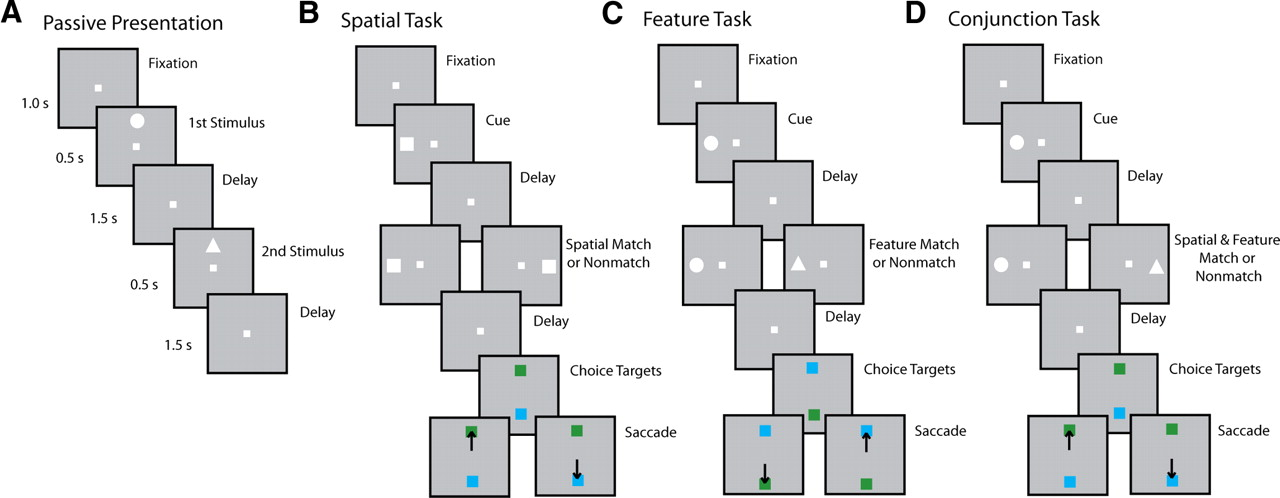

Further details:
* Spatial set involved a white 2° square that appeared randomly in one of nine locations arranged on a 3 x 3 grid with 10° spacing between stimuli.
* When the Sample was in a different location, it was typically in the 'opposite' location.
* The feature set consisted of eight white shapes that were presented at the same location on the screen. The feature stimuli fit within a 2deg square and were equalized for luminance.
* The choice targets were at the locations orthogonal to the Cue and Sample stimuli.
* The Green/Blue location varied randomly from trial to trial.

## Environment Setup

In [ ]:
#@title Run Environment Setup
try:
    # See if we are running on google.colab
    from google.colab import files
    IN_COLAB = True
    !pip install --upgrade nengo nengo-gui nbdev git+https://github.com/neuromorphs/grill-srnn-pfc.git
    !jupyter serverextension enable nengo_gui.jupyter
    # TODO: kaggle creds for downloading data 
    
except ModuleNotFoundError:
    IN_COLAB = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Task Stimulus Encoding - Spatial Only

* We are not (yet?) asking the reply to be to a green vs blue target, only to answer +1 for match or -1 for mismatch.

In [ ]:
#export
import numpy as np
import nengo
import matplotlib.pyplot as plt


class DMSTask:
    phase_names = ['isi', 'cue', 'delay1', 'sample', 'delay2', 'response']
    phase_durs = [1.0, 0.5, 1.5, 0.5, 1.5, 1.0]
    
    def __init__(self, gen_trials_per_cond=5, cond_seed=1337):
        self.cumulative_durs = np.cumsum(self.phase_durs)
        self.trial_dur = self.cumulative_durs[-1]
        self.cue_locs = DMSTask.cue_locations()
        self.targs, self.matches = self.gen_trial_conditions(n_trials_per_cond=gen_trials_per_cond,
                                                             seed=cond_seed)
    
    @staticmethod
    def cue_locations(stim_x=1/np.sqrt(2), stim_y=1/np.sqrt(2)):
        """
        Visual stimulus location: x, y. Will be 0, 0 except during Cue and Sample
        periods. During Cue it will be set to one of 8 possible values on the grid,
        except the centre position.
        """
        return np.array([[-stim_x,  stim_y], [0.0,  stim_y], [stim_x, stim_y],
                         [-stim_x,     0.0],                 [stim_x,    0.0],
                         [-stim_x, -stim_y], [0.0, -stim_y], [stim_x, -stim_y]])
    
    def gen_trial_conditions(self, n_trials_per_cond=5, seed=1337):
        """
        total trials = n_trials_per_cond x 8 stim_locs x 2 match-or-mismatch
        """
        n_locs = len(self.cue_locs)
        result = np.tile(np.arange(n_locs * 2), n_trials_per_cond)
        rng = np.random.default_rng(seed=seed)
        rng.shuffle(result)
        return result % n_locs, 1 - 2*(result >= n_locs)
    
    def gate_signal(self, t):
        """
        Fixation point acts as a hold signal. We'll just use a 1-d value: -1 for hold, +1 for go.
        """
        return 1 - 2 * ((t % self.trial_dur) < self.cumulative_durs[-2])
    
    def stim_signal(self, t):
        trial_ix = int(np.floor(t / self.trial_dur)) % len(self.targs)
        t_trial = t % self.trial_dur
        is_cue = self.cumulative_durs[0] <= t_trial < self.cumulative_durs[1]
        is_samp = (not is_cue) and self.cumulative_durs[2] <= t_trial < self.cumulative_durs[3]
        if is_cue or is_samp:
            cue_loc = self.cue_locs[self.targs[trial_ix]]
            if not is_samp:
                return cue_loc
            return self.matches[trial_ix] * cue_loc
        return [0, 0]

    def ideal_signal(self, t):
        trial_ix = int(np.floor(t / self.trial_dur)) % len(self.targs)
        t_trial = t % self.trial_dur
        if t_trial >= self.cumulative_durs[-2]:
            return self.matches[trial_ix]
        return 0
    
    def plot_inputs(self, n_trials=3, srate=1000):
        t_vec = np.arange(0, self.trial_dur * n_trials, 1 / srate)
        plt.figure(figsize=(8, 5))
        plt.subplot(3, 1, 1)
        plt.plot(t_vec, self.gate_signal(t_vec))
        plt.ylabel('Hold')
        plt.subplot(3, 1, 2)
        plt.plot(t_vec, [self.stim_signal(_) for _ in t_vec])
        plt.ylabel('Target')
        plt.legend(['x', 'y'], loc='upper right')
        plt.subplot(3, 1, 3)
        plt.plot(t_vec, [self.ideal_signal(_) for _ in t_vec])
        plt.ylabel('Ideal')
        plt.tight_layout()


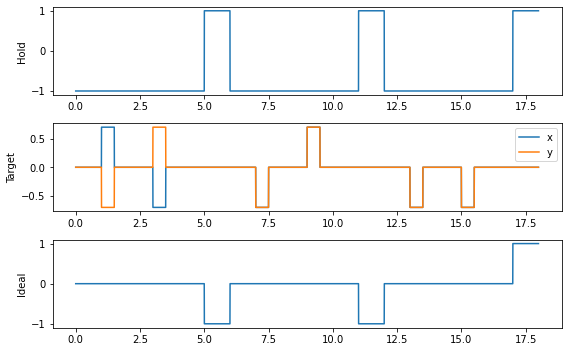

In [ ]:
dms_task = DMSTask()
dms_task.plot_inputs()

## Model Setup - Spatial Task Only

This model is cobbled together from Terry Stewart's ["Nengo for Neuromorphs" tutorial](https://youtu.be/Mo0cenWEz68?t=2298) and the [Nengo documentation](https://www.nengo.ai/nengo/examples/learning/learn-communication-channel.html).

In [ ]:
#export
class SpatialDMSSimple(nengo.Network):
    def __init__(self, tau=0.1, n_neurons=1000, train_trials=80):
        # Task setup
        train_trials_per_cond = int(np.ceil(train_trials / 8 / 2))
        self.dms_task = DMSTask(gen_trials_per_cond=2 * train_trials_per_cond,
                                cond_seed=1337)
        # Input Nodes
        # Fixation: -1 except during response period.
        self.fixation = nengo.Node(self.dms_task.gate_signal, size_out=1, label='fixation')
        # Target: x,y position of target.
        # Usually 0,0, or the target (sample) location during Cue (Sample).
        self.target = nengo.Node(self.dms_task.stim_signal, size_out=2, label='target')
        # Known correct answer
        self.ideal = nengo.Node(self.dms_task.ideal_signal, label='ideal')
        
        # SNN to do the task
        # Combines fixation (dim=0) and target inputs (dim=1,2).
        # Represents output (dim=3) as 0 when fixation high, otherwise...
        # +1 when target and sample match or -1 when mismatch
        self.do_dms = nengo.Ensemble(n_neurons=n_neurons, dimensions=4, label='do_dms', radius=2)
        nengo.Connection(self.fixation, self.do_dms[0], synapse=0.005)
        nengo.Connection(self.target, self.do_dms[1:3], transform=tau, synapse=tau)
        recurr = nengo.Connection(self.do_dms, self.do_dms,
                                  synapse=tau,
                                  learning_rule_type=nengo.PES(learning_rate=1e-4))
        
        # error signal = output - answer
        t_train = self.dms_task.trial_dur * train_trials
        self.error = nengo.Node(lambda t, x: (0, 0, 0, x[0]) if t <= t_train else (0, 0, 0, 0),
                                size_in=1, size_out=4, label='error')
        nengo.Connection(self.do_dms[3], self.error)
        nengo.Connection(self.ideal, self.error, transform=-1)
        nengo.Connection(self.error, recurr.learning_rule)


In [ ]:
from nengo_gui.ipython import IPythonViz

with nengo.Network() as inet:
    inet.dms = SpatialDMSSimple()
IPythonViz(inet)

In [ ]:
def test_dms(net, sim_trials=160):
    with net:
        net.dms = SpatialDMSSimple(train_trials=sim_trials//2)
        
        probes = {
            'fix': nengo.Probe(net.dms.fixation),
            'targ': nengo.Probe(net.dms.target),
            'ideal': nengo.Probe(net.dms.ideal),
            'dms': nengo.Probe(net.dms.do_dms),
            'error': nengo.Probe(net.dms.error)
        }
        
    sim_time = sim_trials * net.dms.dms_task.trial_dur
    with nengo.Simulator(net) as sim:
        sim.run(sim_time)
    return sim, probes

In [ ]:
SIM_TRIALS = 160
net = nengo.Network()
sim, probes = test_dms(net, sim_trials=SIM_TRIALS)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

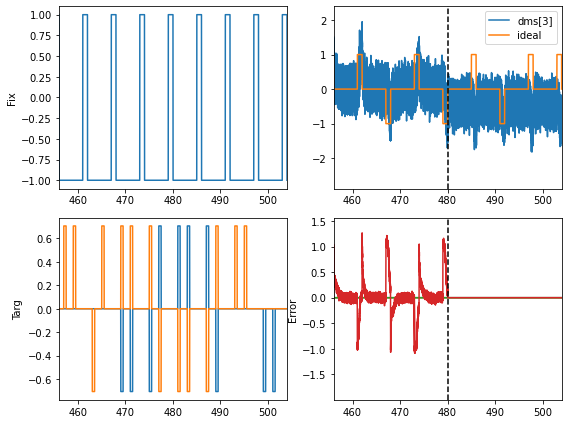

In [ ]:
trial_dur = DMSTask().trial_dur
t = sim.trange()
xrange = [int(SIM_TRIALS//2 * 0.95) * trial_dur,
          int(SIM_TRIALS//2 * 1.05) * trial_dur]

plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(t, sim.data[probes['fix']])
plt.xlim(xrange)
plt.ylabel('Fix')

plt.subplot(2, 2, 3)
plt.plot(t, sim.data[probes['targ']])
plt.xlim(xrange)
plt.ylabel('Targ')

plt.subplot(2, 2, 2)
plt.plot(t, sim.data[probes['dms']][:, -1], label='dms[3]')
plt.plot(t, sim.data[probes['ideal']], label='ideal')
plt.axvline(SIM_TRIALS//2 * trial_dur, color='k', ls='--')
plt.xlim(xrange)
plt.legend()

plt.subplot(2, 2, 4)

plt.plot(t, sim.data[probes['error']], label='error')
plt.axvline(SIM_TRIALS//2 * trial_dur, color='k', ls='--')
plt.xlim(xrange)
plt.ylabel('Error')

plt.tight_layout()